In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Minimal transform just for initial loading
transform = transforms.Compose([
    transforms.ToTensor()  # This is required for visualizing images initially
])

# Loading FashionMNIST dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Print the size of the dataset
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

100%|██████████| 170498071/170498071 [00:13<00:00, 12597745.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training dataset size: 50000
Test dataset size: 10000


Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sample images:


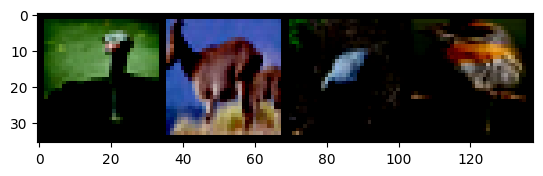

Labels: bird         deer         bird         bird        


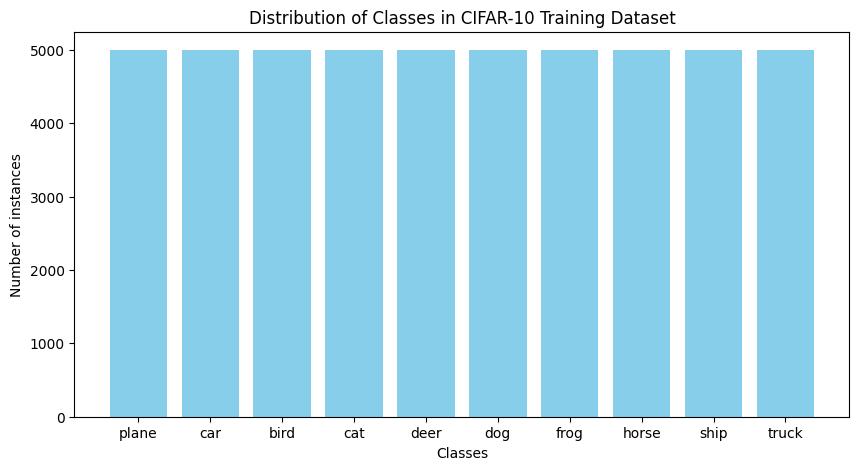

In [ ]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torchvision.transforms as transforms

# Function to show images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
print('Sample images:')
imshow(torchvision.utils.make_grid(images))

# Labels for CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Print corresponding labels
print('Labels:', ' '.join(f'{classes[labels[j]]:12s}' for j in range(4)))

# Plot the distribution of classes in the training dataset
class_counts = {class_name: 0 for class_name in classes}
for _, label in train_dataset:
    class_name = classes[label]
    class_counts[class_name] += 1

# Visualization of the class distribution
plt.figure(figsize=(10,5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of instances')
plt.title('Distribution of Classes in CIFAR-10 Training Dataset')
plt.show()

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations for training and testing
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for single channel grayscale images
])

train_transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for single channel grayscale images
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for single channel grayscale images
])

# Assuming train_dataset and test_dataset are already defined with FashionMNIST
# Split the training dataset into training and validation sets
validation_split = 0.2
train_size = int((1 - validation_split) * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_data, validation_data = random_split(train_dataset, [train_size, validation_size])

# Apply appropriate transformations to each dataset
# train_data.dataset.transform = train_transform  # Non-augmented training data
train_data.dataset.transform = train_transform_augment  # Augmented training data
validation_data.dataset.transform = test_transform  # Non-augmented for validation

# Display sizes of each dataset
print(f"Training Data: {len(train_data)} samples")
print(f"Validation Data: {len(validation_data)} samples")
print(f"Test Data: {len(test_dataset)} samples")

Training Data: 40000 samples
Validation Data: 10000 samples
Test Data: 10000 samples


In [ ]:
#EARLY STOPPING AND TRAINING FUCNTIONS

class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

def train_cnn_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Get only the logits from the model's output which is the first element of the tuple
            output, _ = model(data)  # Adjust here to unpack the tuple and ignore the second output
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                # Again, get only the logits when evaluating
                output, _ = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses


In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Updated to 3 input channels
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 64),  # Updated for CIFAR-10's 32x32 images
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        # Store the output of the last convolutional layer
        last_conv_output = x
        x = self.classifier(x)
        return x, last_conv_output

# Instantiate the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN().to(device)

# Using torchsummary to display model summary
summary(cnn_model, input_size=(3, 32, 32))  # Updated to 3 channels, 32x32 input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           9,248
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
           Dropout-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
             ReLU-10           [-1, 64, 16, 16]               0
        MaxPool2d-11             [-1, 64, 8, 8]               0
          Dropout-12             [-1, 64, 8, 8]               0
          Flatten-13                 [-1, 4096]               0
           Linear-14                   

In [ ]:
batch_size = 512
epochs = 50
patience = 5
lr = 0.001
reg = 0.0001

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#CNN model, criterion, optimizer, and early stopping initialization
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=lr, weight_decay=reg)  # Ensure this is for the cnn_model
early_stopper = EarlyStopping(patience=patience)

# Training the model
train_losses, val_losses = train_cnn_model(epochs, cnn_model, cnn_optimizer, criterion, train_loader, validation_loader, early_stopper)

# Plotting the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch: 1, Training Loss: 2.0215, Validation Loss: 1.7433
Validation loss decreased (1.743285 --> 1.743285).  Saving model ...
Epoch: 2, Training Loss: 1.6965, Validation Loss: 1.4970
Validation loss decreased (1.743285 --> 1.496959).  Saving model ...
Epoch: 3, Training Loss: 1.5492, Validation Loss: 1.3677
Validation loss decreased (1.496959 --> 1.367653).  Saving model ...
Epoch: 4, Training Loss: 1.4459, Validation Loss: 1.3035
Validation loss decreased (1.367653 --> 1.303505).  Saving model ...
Epoch: 5, Training Loss: 1.3879, Validation Loss: 1.2317
Validation loss decreased (1.303505 --> 1.231737).  Saving model ...
Epoch: 6, Training Loss: 1.3235, Validation Loss: 1.1702
Validation loss decreased (1.231737 --> 1.170225).  Saving model ...
Epoch: 7, Training Loss: 1.2725, Validation Loss: 1.1116
Validation loss decreased (1.170225 --> 1.111643).  Saving model ...
Epoch: 8, Training Loss: 1.2220, Validation Loss: 1.0860
Validation loss decreased (1.111643 --> 1.085970).  Saving mo

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

# Function to evaluate the model on the validation set
def evaluate_model(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # If the model returns a tuple, select only the logits
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            y_preds.extend(predicted.view(-1).cpu().numpy())  # Store predictions
            y_true.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_preds)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_true, y_preds, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_preds))

    return accuracy

# Evaluate CNN model
print("\n---------------CNN MODEL---------------\n")
cnn_accuracy = evaluate_model(validation_loader, cnn_model)


---------------CNN MODEL---------------

Accuracy: 0.7166
Classification Report:
               precision    recall  f1-score   support

           0     0.7320    0.7222    0.7271       972
           1     0.8412    0.8716    0.8562       997
           2     0.6442    0.5624    0.6005       985
           3     0.5206    0.5044    0.5123      1029
           4     0.6957    0.6547    0.6746       999
           5     0.6258    0.5842    0.6043      1039
           6     0.7564    0.7797    0.7679       944
           7     0.7459    0.7834    0.7642       997
           8     0.7616    0.9067    0.8279      1029
           9     0.8143    0.8038    0.8090      1009

    accuracy                         0.7166     10000
   macro avg     0.7138    0.7173    0.7144     10000
weighted avg     0.7129    0.7166    0.7136     10000

Confusion Matrix:
 [[702  22  43  14   9   0   3  16 122  41]
 [  8 869   3   2   1   1   6   2  36  69]
 [ 80   3 554  67  92  61  54  34  35   5]
 [ 23   8 